<a href="https://colab.research.google.com/github/przemek-c/robot-arm/blob/main/robot-arm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Draw objects in CAD, get vertices
1. Stop worring about tools - it's best you have
1. Define point as matrix T
2. Calculate IK
1. Check how it looks like
1. Interpolate more points
1. Other part of plan is to make env for work with

In [ ]:
print("Hello")

Hello


### Imports
But before run, first manually choose the GPU T4 workspace

In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


### Define the robot

Imports for RTB

In [ ]:
import google.colab
%pip install roboticstoolbox-python>=1.0.2
# %pip install colored==1.4.4

import numpy as np
import roboticstoolbox as rtb
from spatialmath import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

%matplotlib notebook

In [ ]:
L1 = rtb.DHLink(d=0.0,   alpha=   0.0,   theta=0.0, a=0.0,)
L2 = rtb.DHLink(d=0.0,   alpha= -pi/2,   theta=0.0, a=0.0)
L3 = rtb.DHLink(d=0.42,  alpha=  pi/2,   theta=0.0, a=0.0)
L4= rtb.DHLink( d=0.0,   alpha=  pi/2,   theta=0.0, a=0.0)
L5= rtb.DHLink( d=0.4,   alpha= -pi/2,   theta=0.0, a=0.0)
L6= rtb.DHLink( d=0.0,   alpha= -pi/2,   theta=0.0, a=0.0)
L7= rtb.DHLink( d=0.0,   alpha=  pi/2,   theta=0.0, a=0.0)
robot = rtb.DHRobot([L1, L2, L3, L4, L5, L6, L7])

In [ ]:
QPOS = [
  -1.7     ,
   0.53    ,
  -0.029   ,
  -0.66    ,
   0.12    ,
   0.86    ,
  -0.31
]
T = robot.fkine(QPOS)
print(T)
sol = robot.ikine_LM(T)
sol

   0.5444    0.8245   -0.154     0.0001177  
  -0.7355    0.5575    0.3849    0.2663    
   0.4032   -0.09632   0.91     -0.007111  
   0         0         0         1         



IKSolution(q=array([    -1.8,   0.6304,   -0.029,    -0.66,     0.12,     0.86,    -0.31]), success=True, iterations=9, searches=1, residual=7.577634390789281e-07, reason='Success')

Implement my robot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


""

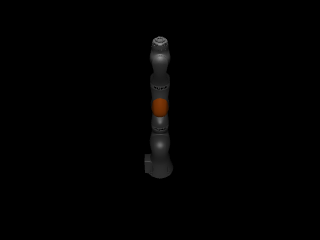

""

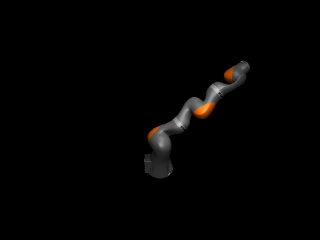

In [3]:
'''
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
'''
# model = mujoco.MjModel.from_xml_string(xml)
# in content dir make maually kuka dir paste whats need to be there, then add dir assets and paste files there separately
# model = mujoco.MjModel.from_xml_path('/content/kuka/iiwa14.xml')
# or get it from the drive
model = mujoco.MjModel.from_xml_path('/content/drive/MyDrive/Colab Notebooks/kuka/iiwa14.xml')
data = mujoco.MjData(model)


renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

# gemini forward kinematics
# Set joint positions (adjust indices as needed)
data.qpos[0] = 0.5
data.qpos[1] = 1.0

# Compute forward kinematics
mujoco.mj_forward(model, data)

# Access the position of a specific site (adjust index as needed)
#site_pos = data.xpos[model.site_adr[0]]

# Access the orientation of a specific body (adjust index as needed)
#body_rot = data.xmat[model.body_adr[0]]

renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

# and on second picture robot is moved
# so now let's make a video